## Baseline model for bus 203

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
sns.set()

In [2]:
bus_line_file = '../bus203_all.csv'

In [3]:
# convert timestamp column to pandas timestamp
df = pd.read_csv(bus_line_file)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

### Split the data random subsets of 80% train, 20% test

In [4]:
journey_ids = df['journey_number'].unique().copy()
print(journey_ids) # journeys should be ordered

[   1    2    3 ... 3662 3663 3664]


In [5]:
# shuffle all the journey numbers
np.random.shuffle(journey_ids)
print(journey_ids) # check that journey ids are now shuffled

[1628 1195  495 ... 3542 2995 1841]


In [6]:
num_journeys = len(journey_ids)
num_train = round(num_journeys * 0.8)

In [7]:
# take 80% of shuffled journey ids as train, the rest as test
train_ids = journey_ids[:num_train]
test_ids = journey_ids[num_train:]

In [8]:
# split data into test and train by the ids
train = df[df['journey_number'].isin(train_ids)]
test = df[df['journey_number'].isin(test_ids)]

In [9]:
# sanity check
print('train data rows comprise {:.4f}% of the total data'.format(len(train.index) / len(df.index)))
print('test data rows comprise {:.4f}% of the total data'.format(len(test.index) / len(df.index)))

train data rows comprise 0.7998% of the total data
test data rows comprise 0.2002% of the total data


### Calculate the average segment time for each segment in the train data

In [10]:
def duration(x):
    timedelta = x.max() - x.min()
    return timedelta.seconds

We need to calculate the duration of the segments in both the test and train data:

In [11]:
train['segment_time'] = train.groupby(['journey_number', 'segment_number'])['timestamp'].transform(duration)
test['segment_time'] = test.groupby(['journey_number', 'segment_number'])['timestamp'].transform(duration)

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The warning above is a false positive..


In [12]:
train.head(1)

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,segment_time
0,0,2018-02-16 04:48:40+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.0,-1.0,NaN,1,1,72


In [71]:
def interval_time(x):
    timedelta = x['timestamp'].max() - x['timestamp'].min()
    return timedelta.seconds

In [80]:
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    indexes = [math.floor(seg_len * i/10) for i in range(2, 10, 2)]
    interval_data = []
    for idx in indexes:
        interval_data.append(interval_time(group[idx:]))
    data.append([name[1]] + interval_data)

In [81]:
pred_df = pd.DataFrame(columns=['sn', '20_p', '40_p', '60_p', '80_p'], data=data)

In [105]:
pred_df = pred_df.groupby('sn').median().reset_index()

In [106]:
pred_df

,sn,20_p,40_p,60_p,80_p
0,1,152,113,74,38
1,2,46,35,23,11
2,3,52,40,26,13
3,4,34,26,17,8
4,5,43,32,21,10
5,6,49,38,25,12
6,7,81,61,41,20
7,8,37,28,19,9
8,9,128,96,64,31
9,10,59,45,30,15


In [77]:
pickle.dump(pred_df, open('prediction_df_203.p', 'wb'))

Now we want to get the average time it took to drive each segment. Since we have the segment time duplicated over all rows with the same journey number and segment number, we need to only take this number once to not get a skewed weighting of the average. We can group by `journey_number` and `segment_number`, and take any aggregate function (min, max, mean) since the segment time is the same for each row where the journey number and segment number are the same.

In [13]:
a = train.groupby(['journey_number', 'segment_number']).min().reset_index()

In [14]:
import pickle
pickle.dump(a, open('203_segs.p', 'wb'))

In [15]:
a['segment_time'].median()

66.0

In [16]:
a['segment_time'].mean()

83.43421717171717

In [17]:
averages = dict(a.groupby('segment_number')['segment_time'].median())
averages

{1: 188,
 2: 56,
 3: 63,
 4: 43,
 5: 52,
 6: 61,
 7: 100,
 8: 46,
 9: 157,
 10: 73,
 11: 69}

The dict above holds our average segment durations, which will be used to make predictions on the test set.

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through all segments in the test data for each journey and subtract the average segment time from the actual segment time. We can then calculate how big the error was, expressed as a percentage of the actual segment time. 

In [42]:
import math

In [64]:
def get_prediction_error(start_time, segment_name, segment_data):
    # min() becomes the min timestamp of this slice, 
    # while start_time is the min timestamp on the whole segment 
    timedelta = segment_data['timestamp'].min() - start_time
    # get how much time the bus has already spent in this slice of the segment
    time_passed = timedelta.seconds
    # subtract that from the total time the segment takes    
    time_left = segment_data['segment_time'].iloc[0] - time_passed
    # subtract the spend time from our prediction as well
    time_pred = averages[segment_name] - time_passed
    # get the error in seconds from our prediction vs the true travel time
    error_s = time_left - time_pred
    # get error as a percentage of the true travel time left
    error_p = error_s / time_left * 100
    # get absolute values of the errors
    abs_error_s = abs(error_s)
    abs_error_p = abs(error_p)
    return error_s, error_p, abs_error_s, abs_error_p

In [131]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    indexes = [math.floor(seg_len * i/10) for i in range(2, 10, 2)]
    # calculate our errors for each slice of the segment
    for idx, pred in zip(indexes, pred_df.columns[1:]):
        timedelta = group[idx:]['timestamp'].max() - group[idx:]['timestamp'].min()
        seg_time = timedelta.seconds
        error_s = seg_time - pred_df[pred_df.sn == name[1]][pred].iloc[0]
        # get error as a percentage of the ground truth segment travel time
        error_p = error_s / seg_time * 100
        # get the absolute values of the errors in seconds and as a percentage
        abs_error_s = abs(error_s)
        abs_error_p = abs(error_p)
        data.append([name[1], pred, error_s, error_p, abs_error_s, abs_error_p])

In [132]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [133]:
error_df

,segment,slice,error_s,error_p,abs_error_s,abs_error_p
0,1,20_p,-57,-0.600000,57,0.600000
1,1,40_p,-43,-0.614286,43,0.614286
2,1,60_p,-26,-0.541667,26,0.541667
3,1,80_p,-15,-0.652174,15,0.652174
4,2,20_p,-3,-0.069767,3,0.069767
5,2,40_p,-2,-0.060606,2,0.060606
6,2,60_p,-1,-0.045455,1,0.045455
7,2,80_p,-1,-0.100000,1,0.100000
8,3,20_p,-4,-0.083333,4,0.083333
9,3,40_p,-3,-0.081081,3,0.081081


In [18]:
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    # get error in seconds
    error_s = group['segment_time'].iloc[0] - averages[name[1]]
    # get error as a percentage of the ground truth segment travel time
    error_p = error_s / group['segment_time'].iloc[0] * 100
    # get the absolute values of the errors in seconds and as a percentage
    abs_error_s = abs(error_s)
    abs_error_p = abs(error_p)
    data.append([name[0], name[1], error_s, abs_error_s, error_p, abs_error_p])

In [19]:
time_diffs = pd.DataFrame(columns=['journey_number', 'segment_number', 'error_s', 'abs_error_s', 'error_p', 'abs_error_p'], data=data)

In [20]:
time_diffs.head(5)

,journey_number,segment_number,error_s,abs_error_s,error_p,abs_error_p
0,8,1,-71,71,-60.683761,60.683761
1,8,2,-3,3,-5.660377,5.660377
2,8,3,-3,3,-5.000000,5.000000
3,8,4,-22,22,-104.761905,104.761905
4,8,5,-5,5,-10.638298,10.638298


This is our combined *mean absolute percentage error* (MAPE) for all the segments in the test set:

In [21]:
print('combined MAPE for all segments: {:.3f}%'.format(time_diffs.abs_error_p.mean()))

combined MAPE for all segments: 23.267%


We can also look at the MAPE in each of the segments:

In [22]:
seg_mapes = time_diffs.groupby('segment_number')['abs_error_p'].mean()
for i, mape in enumerate(seg_mapes):
    print('Segment {}: \t{:.3f}%'.format(i+1, mape))

Segment 1: 	15.054%
Segment 2: 	25.224%
Segment 3: 	18.894%
Segment 4: 	43.722%
Segment 5: 	16.703%
Segment 6: 	20.929%
Segment 7: 	13.935%
Segment 8: 	38.917%
Segment 9: 	11.107%
Segment 10: 	24.336%
Segment 11: 	27.117%


We can also look at the absolute error in seconds:

In [23]:
print('combined error in seconds for all segments: {:.3f}s'.format(time_diffs.abs_error_s.mean()))

combined error in seconds for all segments: 14.720s


And we can also look at the error in seconds for each segment:

In [24]:
seg_err_s = time_diffs.groupby('segment_number')['abs_error_s'].mean()
for i, err in enumerate(seg_err_s):
    print('Segment {}: \t{:.1f}s'.format(i+1, err))

Segment 1: 	24.8s
Segment 2: 	11.5s
Segment 3: 	10.4s
Segment 4: 	13.2s
Segment 5: 	10.6s
Segment 6: 	11.2s
Segment 7: 	14.9s
Segment 8: 	12.8s
Segment 9: 	18.8s
Segment 10: 	16.8s
Segment 11: 	16.7s


## Plotting the histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


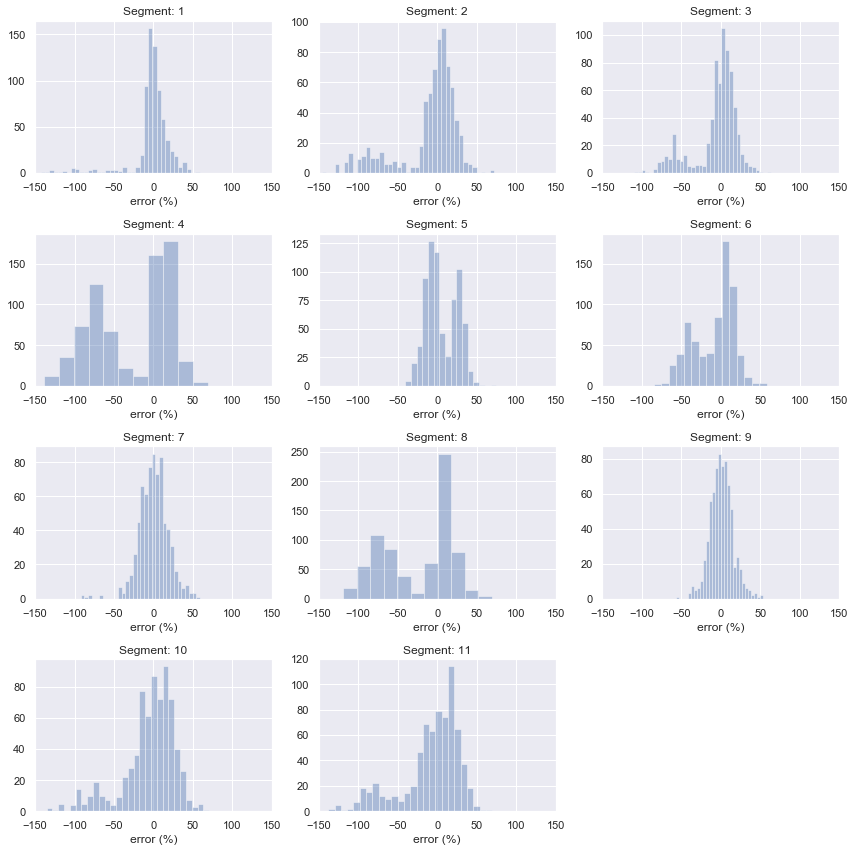

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(time_diffs[time_diffs['segment_number'] == i+1].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


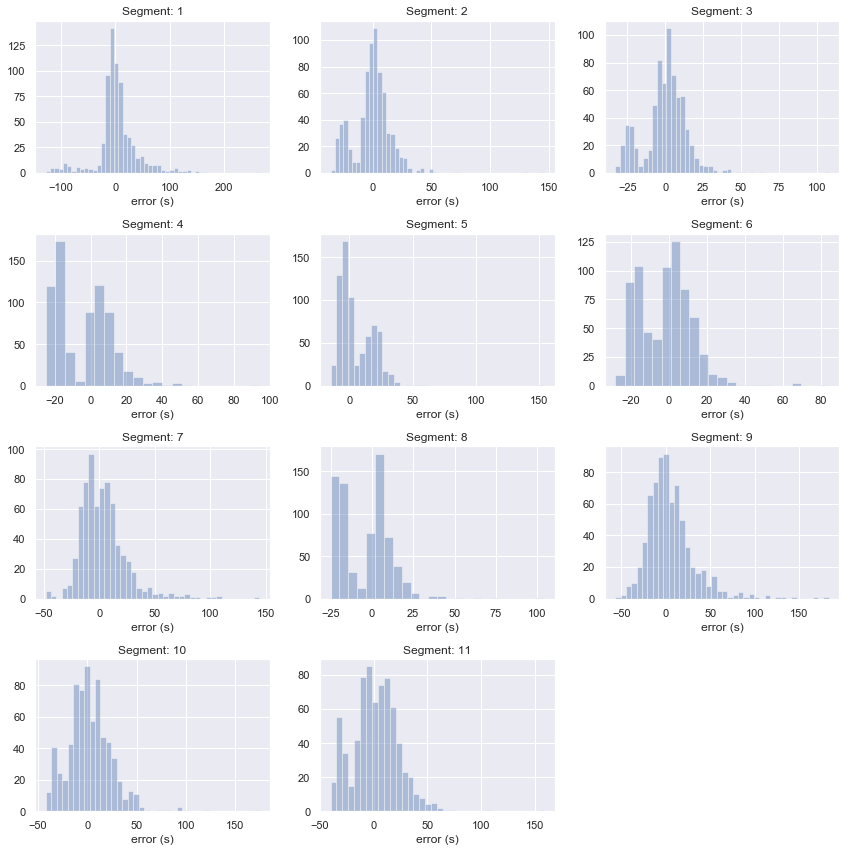

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(time_diffs[time_diffs['segment_number'] == i+1].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (s)')
fig.delaxes(ax)
plt.tight_layout()
plt.show()